In [94]:
import os
import sys
sys.path.append(os.path.join('D:', os.sep, 'Users', 'Julien', 'Documents', 'GitHub', 'diploma_thesis', 'cnn'))
import numpy as np
import matplotlib.pyplot as plt
import torch
print(f'Torch version: {torch.__version__}')
from collections import namedtuple
Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")
from datetime import timedelta
from matplotlib.ticker import MultipleLocator

Torch version: 1.7.1


# Constants

In [2]:
gpu = "v100"
seeds = [1124, 2554, 3141, 5520, 7478]
main_dir = os.path.join('H:', os.sep, 'DA_Results')

# Load Checkpoints

In [3]:
checkpoints_search = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false', gpu, 'grid_search-batch_size_256', f'search_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
checkpoints_eval_psi_same = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false', gpu, 'grid_search-batch_size_256', f'evaluation_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
checkpoints_eval_psi_const = {seed: torch.load(os.path.join(main_dir, 'exp_1_data-shuffle_false_constant_channels', gpu, 'grid_search-batch_size_256', f'evaluation_phase_seed_{seed}', 'outer_loop.ckpt')) for seed in seeds}
all_checkpoints = [checkpoints_search, checkpoints_eval_psi_same, checkpoints_eval_psi_const]

init_channels_searched = []
for ckpt in all_checkpoints:
    for seed in seeds:
        channels = []
        for init_channels, values in ckpt[seed]['history'].items():
            if any(['error' in x for x in values.keys()]):
                continue
            else:
                channels.append(init_channels)
                
        init_channels_searched.append(channels)
        
assert init_channels_searched.count(init_channels_searched[0]) == len(init_channels_searched), "Different channels evaluated"
init_channels_searched = init_channels_searched[0]
print(f"Searched initial channels: {init_channels_searched}")

Searched initial channels: [4, 8, 12, 16, 20, 24, 28, 32, 36]


In [4]:
all_checkpoints[2][seeds[0]]['history'][24]

{'checkpoint_path': '/beegfs/global0/ws/s8732099-diploma_thesis/experiments_da/exp_1_data-shuffle_false_constant_channels/v100/grid_search-batch_size_256/evaluation_phase_seed_1124/checkpoints/checkpoint_init_channels_24/model_best.ckpt',
 'best_weights_train_time': 24410.579350595362,
 'train_acc': 99.875,
 'valid_acc': 96.44071960449219,
 'overall_eval_time': 24782.956365794875,
 'max_mem_allocated_MB': 9432.649216,
 'max_mem_reserved_MB': 10427.039744,
 'model_parameters': 3285120}

In [5]:
all_checkpoints[0][seeds[0]]['history'][24]

{'best_genotype': Genotype(normal=[('skip_connect', 0), ('skip_connect', 1), ('skip_connect', 2), ('sep_conv_3x3', 1), ('skip_connect', 3), ('sep_conv_5x5', 1), ('sep_conv_3x3', 0), ('max_pool_3x3', 4)], normal_concat=range(2, 6), reduce=[('max_pool_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_5x5', 2), ('sep_conv_5x5', 1), ('max_pool_3x3', 2), ('max_pool_3x3', 0), ('sep_conv_5x5', 2), ('sep_conv_5x5', 4)], reduce_concat=range(2, 6)),
 'best_genotype_search_time': 13069.953314775601,
 'search_train_acc': 93.305,
 'search_valid_acc': 85.06,
 'overall_search_time': 13641.48736474663,
 'max_mem_allocated_MB': 17215.468544,
 'max_mem_reserved_MB': 19425.918976}

# Variables to store the parsed checkpoints

In [28]:
results_averaged = {x: {} for x in ["search", "same", "const"]} # used for tables
plot_arrays = {x: {} for x in ["search", "same", "const"]} # used for plots

# Parse checkpoints and average

In [101]:
for i, ckpt in enumerate(all_checkpoints):
    search = False
    if i == 0:
        search = True
    # for mean / std calculation
    all_seeds_train = {channels: [] for channels in init_channels_searched}
    all_seeds_valid = {channels: [] for channels in init_channels_searched}
    all_seeds_runtime = {channels: [] for channels in init_channels_searched}
    all_seeds_mem = {channels: [] for channels in init_channels_searched}
    if not search:
        all_seeds_parameters = {channels: [] for channels in init_channels_searched}

    for seed in seeds: 
        for init_channels in init_channels_searched:
            vals = ckpt[seed]['history'][init_channels]
            all_seeds_train[init_channels].append(vals['search_train_acc'] if search else vals['train_acc'])
            all_seeds_valid[init_channels].append(vals['search_valid_acc'] if search else vals['valid_acc'])
            all_seeds_runtime[init_channels].append(vals['overall_search_time'] if search else vals['overall_eval_time'])
            all_seeds_mem[init_channels].append(vals['max_mem_allocated_MB'])
            if not search:
                all_seeds_parameters[init_channels].append(vals['model_parameters'])

    for init_channels in init_channels_searched:
        train = np.asarray(all_seeds_train[init_channels])
        valid = np.asarray(all_seeds_valid[init_channels])
        runtime = np.asarray(all_seeds_runtime[init_channels])
        mem = np.asarray(all_seeds_mem[init_channels])
        if not search:
            parameters = np.asarray(all_seeds_parameters[init_channels])

        # Average --> mean / std
        results_averaged[list(results_averaged.keys())[i]][init_channels] = {
            'train': {
                'mean': np.mean(train),
                'std': np.std(train)
            },
            'valid': {
                'mean': np.mean(valid),
                'std': np.std(valid)
            },
            'mem': {
                'mean': np.mean(mem),
                'std': np.std(mem)
            },
            'runtime': {
                'mean': str(timedelta(seconds=np.mean(runtime))).split('.')[0],
                'std': str(timedelta(seconds=np.std(runtime))).split('.')[0]
            },
            'runtime_raw': {
                'mean': np.mean(runtime),
                'std': np.std(runtime)
            }
        }
        if not search:
            results_averaged[list(results_averaged.keys())[i]][init_channels]['parameters'] = {
                'mean': np.mean(parameters),
                'std': np.std(parameters)
            }
            
# create numpy arrays for plots
for phase in ["search", "same", "const"]:
    for metric in ["train", "valid", "mem", "runtime_raw", "parameters"]:
        if phase == "search" and metric == "parameters":
            continue
        if not metric in plot_arrays[phase].keys():
            plot_arrays[phase][metric] = {}
        for dist in ['mean', 'std']:
            plot_arrays[phase][metric][dist] = np.asarray([results_averaged[phase][zeta][metric][dist] for zeta in init_channels_searched])

# Latex average table for search phase

In [8]:
bottomrule = " \\bottomrule"
print("$\zeta_\mathrm{search}$ & Runtime (h:mm:ss) & $\\text{GPU Mem (MiB)}^\dagger$ & train\_error (\%) & valid\_error (\%) \\\\ \midrule")
for i, init_channels in enumerate(init_channels_searched):
    print(
        f"${init_channels}$ & "
        f"${results_averaged['search'][init_channels]['runtime']['mean']} \\pm {results_averaged['search'][init_channels]['runtime']['std']}$ & "
        f"${round(results_averaged['search'][init_channels]['mem']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['mem']['std'], 2)}$ & "
        f"${round(100 - results_averaged['search'][init_channels]['train']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['train']['std'], 2)}$ & "
        f"${round(100 - results_averaged['search'][init_channels]['valid']['mean'], 2)} \\pm {round(results_averaged['search'][init_channels]['valid']['std'], 2)}$ \\\\"
        f"{bottomrule if i == len(init_channels_searched)-1 else ''}"
    )

$\zeta_\mathrm{search}$ & Runtime (h:mm:ss) & $\text{GPU Mem (MiB)}^\dagger$ & train\_error (\%) & valid\_error (\%) \\ \midrule
$4$ & $6:18:09 \pm 0:16:03$ & $2900.58 \pm 0.0$ & $24.46 \pm 1.01$ & $26.58 \pm 1.09$ \\
$8$ & $3:24:33 \pm 0:07:16$ & $5715.9 \pm 2.87$ & $15.5 \pm 1.01$ & $20.0 \pm 0.74$ \\
$12$ & $3:32:24 \pm 0:06:13$ & $8665.62 \pm 2.69$ & $11.0 \pm 0.22$ & $17.29 \pm 0.28$ \\
$16$ & $3:35:21 \pm 0:00:57$ & $11339.04 \pm 3.17$ & $8.66 \pm 0.26$ & $15.81 \pm 0.37$ \\
$20$ & $3:43:51 \pm 0:02:45$ & $14170.99 \pm 0.7$ & $7.07 \pm 0.21$ & $15.18 \pm 0.18$ \\
$24$ & $3:48:55 \pm 0:01:40$ & $17225.49 \pm 8.18$ & $6.16 \pm 0.51$ & $14.76 \pm 0.4$ \\
$28$ & $3:54:05 \pm 0:00:32$ & $20263.51 \pm 4.98$ & $5.21 \pm 0.21$ & $14.48 \pm 0.3$ \\
$32$ & $3:59:46 \pm 0:02:18$ & $22603.51 \pm 0.7$ & $4.6 \pm 0.36$ & $14.22 \pm 0.24$ \\
$36$ & $4:07:34 \pm 0:01:17$ & $25433.23 \pm 7.85$ & $4.09 \pm 0.19$ & $13.6 \pm 0.13$ \\ \bottomrule


# Latex average table for same and constant evaluation phases

In [9]:
midrule = " \midrule"
bottomrule = " \\bottomrule"
print("$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & Runtime (h:mm:ss) & $\\text{GPU Mem (MiB)}^\dagger$ & Parameters & train\_error (\%) & valid\_error (\%) \\\\ \midrule")
for Psi in ["same", "const"]:
    for i, init_channels in enumerate(init_channels_searched):
        print(
            f"${init_channels}$ & ${init_channels if Psi == 'same' else 36}$ & "
            f"${results_averaged[Psi][init_channels]['runtime']['mean']} \\pm {results_averaged[Psi][init_channels]['runtime']['std']}$ & "
            f"${round(results_averaged[Psi][init_channels]['mem']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['mem']['std'], 2)}$ &"
            f"${round(results_averaged[Psi][init_channels]['parameters']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['parameters']['std'], 2)}$ & "
            f"${round(100 - results_averaged[Psi][init_channels]['train']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['train']['std'], 2)}$ & "
            f"${round(100 - results_averaged[Psi][init_channels]['valid']['mean'], 2)} \\pm {round(results_averaged[Psi][init_channels]['valid']['std'], 2)}$ \\\\"
            f"{midrule if (i == len(init_channels_searched)-1) and (Psi == 'same') else ''}{bottomrule if (i == len(init_channels_searched)-1) and (Psi == 'const') else ''}"
        )

$\zeta_\mathrm{search}$ & $\zeta_\mathrm{eval}$ & Runtime (h:mm:ss) & $\text{GPU Mem (MiB)}^\dagger$ & Parameters & train\_error (\%) & valid\_error (\%) \\ \midrule
$4$ & $4$ & $9:08:02 \pm 0:54:53$ & $1382.15 \pm 125.94$ &$499347.2 \pm 7236.06$ & $6.04 \pm 1.42$ & $7.92 \pm 0.97$ \\
$8$ & $8$ & $8:11:34 \pm 1:03:06$ & $2519.67 \pm 330.78$ &$641557.6 \pm 26761.96$ & $2.42 \pm 0.36$ & $6.31 \pm 0.3$ \\
$12$ & $12$ & $8:54:22 \pm 1:30:13$ & $4158.42 \pm 596.3$ &$892545.6 \pm 59737.33$ & $0.95 \pm 0.34$ & $4.99 \pm 0.39$ \\
$16$ & $16$ & $8:40:29 \pm 1:41:06$ & $5108.71 \pm 697.58$ &$1166967.2 \pm 88077.44$ & $0.78 \pm 0.3$ & $4.74 \pm 0.33$ \\
$20$ & $20$ & $8:52:10 \pm 0:37:33$ & $6445.07 \pm 422.24$ &$1589392.0 \pm 83851.02$ & $0.51 \pm 0.36$ & $4.44 \pm 0.34$ \\
$24$ & $24$ & $7:30:57 \pm 0:52:12$ & $6754.9 \pm 652.04$ &$1841340.0 \pm 151612.37$ & $0.32 \pm 0.14$ & $3.94 \pm 0.13$ \\
$28$ & $28$ & $8:02:28 \pm 2:06:23$ & $8509.68 \pm 1870.82$ &$2412329.6 \pm 438818.59$ & $0.26 \pm 0.

# Plots for search phase

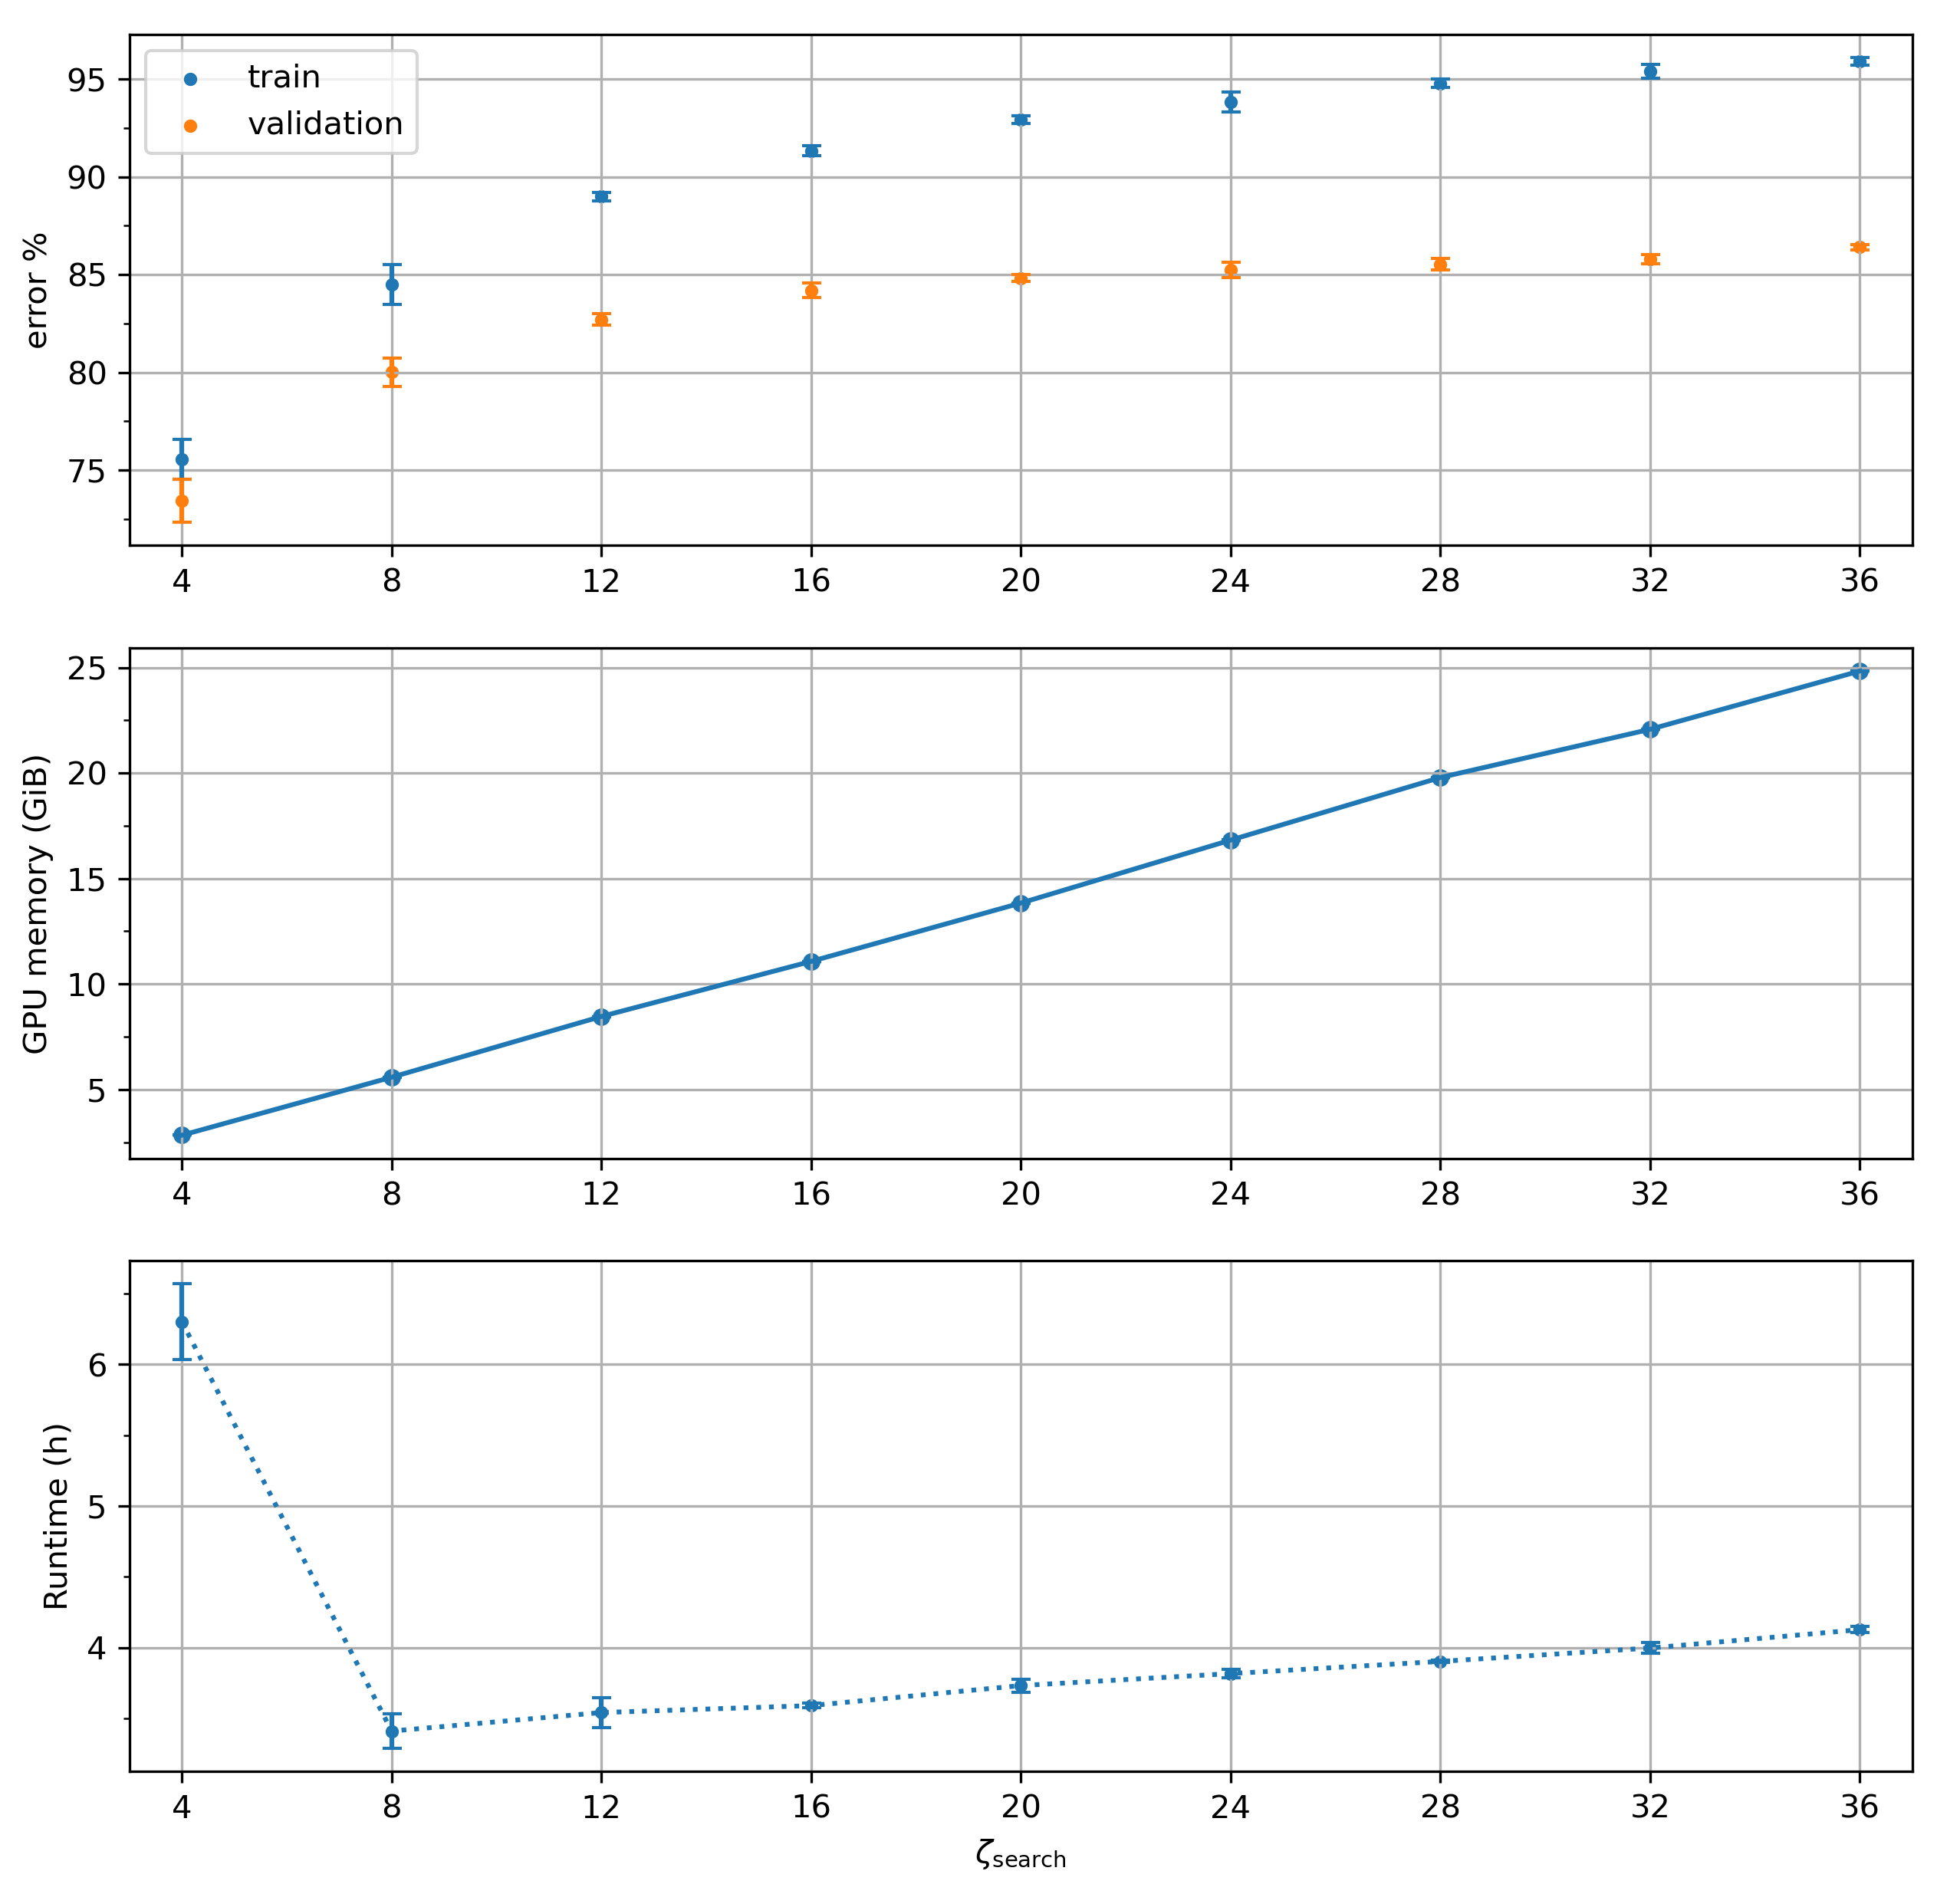

In [126]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 10), dpi=300)
#fig.suptitle(
#    (
#        "Train and validation error, GPU memory consumption and runtime of\n"
#        r"the search phase for different $\zeta_\mathrm{search}$ over 5 random seeds"
#        f"\non a single NVIDIA {gpu.upper()} GPU"
#    ), y=0.96)
overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel(r'$\zeta_\mathrm{search}$')

error = fig.add_subplot(311)
mem = fig.add_subplot(312)
runtime = fig.add_subplot(313)
for ax in fig.get_axes()[1:]:
    ax.yaxis.set_minor_locator(MultipleLocator(2.5))
    ax.grid()
    ax.set_xlim([init_channels_searched[0]-1, init_channels_searched[-1]+1])
    ax.set_xticks(init_channels_searched)
runtime.yaxis.set_minor_locator(MultipleLocator(0.5))
    
# plot train and validation error
error.errorbar(
    init_channels_searched, 
    plot_arrays['search']['train']['mean'], 
    plot_arrays['search']['train']['std'],
    fmt="None",
    capsize=3,
    color="C0"
)
error.errorbar(
    init_channels_searched,
    plot_arrays['search']['valid']['mean'],
    plot_arrays['search']['valid']['std'],
    fmt="None",
    capsize=3,
    color="C1"
)
error.scatter(
    init_channels_searched,
    plot_arrays['search']['train']['mean'],
    s = 10,
    marker="o",
    color="C0"
)
error.scatter(
    init_channels_searched,
    plot_arrays['search']['valid']['mean'],
    s=10,
    marker="o",
    color="C1"
)
error.set_ylabel("error %")
error.legend(
    ['train', 'validation']
)

# plot gpu memory consumption
mem.errorbar(
    init_channels_searched,
    plot_arrays['search']['mem']['mean']/1024,
    plot_arrays['search']['mem']['std']/1024,
    fmt="None",
    capsize=3,
    color="C0"
)
mem.scatter(
    init_channels_searched,
    plot_arrays['search']['mem']['mean']/1024,
    s=20,
    marker="o",
    color="C0"
)
mem.plot(
    init_channels_searched,
    plot_arrays['search']['mem']['mean']/1024,
    color="C0"
)
mem.set_ylabel("GPU memory (GiB)")

# plot runtimes
runtime.errorbar(
    init_channels_searched,
    plot_arrays['search']['runtime_raw']['mean']/3600,
    plot_arrays['search']['runtime_raw']['std']/3600,
    fmt='None',
    capsize=3,
    color="C0"
)
runtime.scatter(
    init_channels_searched,
    plot_arrays['search']['runtime_raw']['mean']/3600,
    s=10,
    marker='o',
    color="C0"
)
runtime.plot(
    init_channels_searched,
    plot_arrays['search']['runtime_raw']['mean']/3600,
    linestyle="dotted",
    color="C0"
)
runtime.set_ylabel("Runtime (h)")
plt.savefig("images/exp_1_search.svg", bbox_inches="tight")

plt.show()

# Plots for evaluation phases